In [1]:
#!/usr/bin/env python3
"""
ANN Benchmark Plots: Build Time + Latency + Throughput vs Recall
----------------------------------------------------------------

Reimplements the plotting logic you asked for, using two CSV inputs
(CAGRA + HNSW grid‑search results). Produces three figures:

1. Avg Index Build Time Seconds vs Recall Brackets (80–90%, 90–95%, 95–99%, ≥99%).
2. avg_query_latency_ms vs Recall (line plot; CAGRA & HNSW).
3. queries_per_second vs Recall (line plot; CAGRA & HNSW).

Usage (script form):
    python ann_plots.py \
        --cagra /path/to/cagra.csv \
        --hnsw /path/to/hnsw.csv \
        --outdir /path/to/output_dir

In a notebook, just set the two paths and call `main_notebook(...)`.

Assumptions
-----------
* CAGRA CSV has:
    build_time_seconds, avg_query_latency_ms, queries_per_second, recall
* HNSW CSV has:
    build_time_seconds, avg_query_latency_ms, queries_per_second, recall
  (If `recall` is missing but `k-nn` is present, that is used.)
* Rows with missing recall are dropped.
* Empty recall brackets produce NaNs (and therefore empty bars) — same as
  the original logic (avg across rows in range; no bar if no rows).

Changes in this version
-----------------------
* **Pareto frontier plots** for latency and throughput now use **solid lines with circle
  markers** for each point instead of dashed diamond markers.
* A grid layout (`ax.grid(True, which="both")`) is enforced even when only the
  frontier is plotted (`frontier_only=True`).
* **Build‑time bar plot** now annotates each bar with its value on top for
  quick readability.
"""

from __future__ import annotations

import argparse
from pathlib import Path
from typing import Iterable, List, Tuple, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# Column‑mapping utilities
# ------------------------------------------------------------------
import json

DEFAULT_COLMAP = {
    "build_time_s":   ["build_time_seconds", "build_time_s"],
    "latency_ms":     ["avg_query_latency_ms", "latency_ms"],
    "throughput_qps": ["queries_per_second", "throughput_qps", "throughput"],
    "recall":         ["recall", "k-nn"],
}

def load_colmap(path: str | Path | None) -> dict[str, list[str]]:
    """Return the user‑supplied mapping if given, else the defaults."""
    if path is None:
        return DEFAULT_COLMAP
    with open(path) as f:
        user_map = json.load(f)
    merged = DEFAULT_COLMAP.copy()
    merged.update(user_map)
    return merged

# ------------------------------------------------------------------
# Data loading / harmonisation
# ------------------------------------------------------------------

def _std_col(df: pd.DataFrame, cand_names: Iterable[str], new_name: str):
    """Create/overwrite df[new_name] from the first candidate name found."""
    for c in cand_names:
        if c in df.columns:
            df[new_name] = df[c]
            return
    df[new_name] = np.nan


def load_benchmark_csvs(
    paths: List[Tuple[Path, str]],
    colmap: dict[str, list[str]],
) -> pd.DataFrame:
    """Load and harmonise multiple benchmark CSVs into one DataFrame."""
    dfs = []
    for p, algo in paths:
        df = pd.read_csv(p).copy()
        df["algo"] = algo
        for canon, aliases in colmap.items():
            _std_col(df, aliases, canon)
        dfs.append(df)

    df_all = pd.concat(dfs, ignore_index=True, sort=False)
    return df_all.dropna(subset=["recall"])

# ------------------------------------------------------------------
# Build‑time bracket aggregation
# ------------------------------------------------------------------
BRACKETS: Dict[str, Tuple[float, float]] = {
    "80-90%": (0.80, 0.90),
    "90-95%": (0.90, 0.95),
    "95-99%": (0.95, 0.99),
    "99%+":  (0.99, 1.01),
}

def build_time_bracket_df(df: pd.DataFrame) -> pd.DataFrame:
    """Average build time per recall bracket per algorithm."""
    rows = []
    for algo, grp in df.groupby("algo"):
        for label, (lo, hi) in BRACKETS.items():
            mean_bt = grp.loc[(grp["recall"] >= lo) & (grp["recall"] < hi), "build_time_s"].mean()
            rows.append({"bracket": label, "algo": algo, "build_time_s": mean_bt})
    return pd.DataFrame(rows)


def _annotate_bars(ax):
    """Attach a text label displaying height on each bar."""
    for p in ax.patches:
        height = p.get_height()
        if np.isnan(height):
            continue
        ax.annotate(
            f"{height:.0f}",
            xy=(p.get_x() + p.get_width() / 2, height),
            xytext=(0, 3),
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=8,
        )


def plot_build_time_bars(df: pd.DataFrame, ax=None):
    """Grouped bar chart of avg build time across recall brackets for each algo."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    else:
        fig = ax.figure

    bt_df = build_time_bracket_df(df)
    bt_wide = bt_df.pivot(index="bracket", columns="algo", values="build_time_s").loc[list(BRACKETS.keys())]

    bt_wide.plot.bar(ax=ax)
    ax.set_ylabel("Avg Index Build Time (s)")
    ax.set_xlabel("Recall Bracket")
    ax.set_title("Avg Index Build Time Seconds vs Recall Brackets")
    ax.grid(True, axis="y")
    _annotate_bars(ax)

    return fig, ax

# ------------------------------------------------------------------
# Metric vs recall plotting
# ------------------------------------------------------------------

def plot_metric_vs_recall(df: pd.DataFrame, metric: str, ylabel: str, title: str, ax=None, xlim_start: float = 0.0):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    else:
        fig = ax.figure

    for algo, grp in df.groupby("algo"):
        g = grp.sort_values("recall")
        ax.plot(g["recall"], g[metric], marker="o", label=algo)

    ax.set_xlabel("Recall")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xlim(left=xlim_start, right=1.0)
    ax.grid(True, which="both")
    ax.legend()

    return fig, ax


def plot_latency_vs_recall(df: pd.DataFrame, **kw):
    return plot_metric_vs_recall(df, metric="latency_ms", ylabel="avg_query_latency_ms", title="Avg Query Latency vs Recall", **kw)


def plot_throughput_vs_recall(df: pd.DataFrame, **kw):
    return plot_metric_vs_recall(df, metric="throughput_qps", ylabel="queries_per_second", title="Queries Per Second vs Recall", **kw)

# ------------------------------------------------------------------
# Pareto frontier utilities
# ------------------------------------------------------------------

def pareto_frontier(df: pd.DataFrame, x: str = "recall", y: str = "latency_ms", bigger_is_better_y: bool = False) -> pd.DataFrame:
    keep_rows = []
    for algo, grp in df.groupby("algo"):
        g = grp.sort_values(y, ascending=not bigger_is_better_y)
        best_x = -np.inf
        for _, row in g.iterrows():
            if row[x] > best_x:
                best_x = row[x]
                keep_rows.append(row)
    return pd.DataFrame(keep_rows)


def plot_metric_vs_recall_with_frontier(df: pd.DataFrame, metric: str, ylabel: str, title: str, frontier_bigger_is_better_y: bool, out_png: Path, line_plot_fn, frontier_only: bool = False):
    if frontier_only:
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.grid(True, which="both")
    else:
        fig, ax = line_plot_fn(df)

    fr_df = pareto_frontier(df, x="recall", y=metric, bigger_is_better_y=frontier_bigger_is_better_y)

    for algo, grp in fr_df.groupby("algo"):
        g = grp.sort_values("recall")
        ax.plot(g["recall"], g[metric], linestyle="-", linewidth=2.5, marker="o", markersize=6, label=f"{algo} (frontier)")

    ax.set_title(title + " (with Pareto frontier)")
    ax.set_xlabel("Recall")
    ax.set_ylabel(ylabel)
    ax.set_xlim(left=0.0, right=1.0)
    ax.grid(True, which="both")
    ax.legend()

    fig.savefig(out_png.with_name(out_png.stem + "_frontier.png"), bbox_inches="tight")
    return fig, ax

def main(
    cagra_csv: Path,
    hnsw_csv: Path,
    outdir: Path,
    show: bool = False,
    frontier_only: bool = False,
    colmap_json: Path | None = None,                    # <<< new
):
    outdir = Path(outdir)
    outdir.mkdir(parents=True, exist_ok=True)

    # load the mapping first
    colmap = load_colmap(colmap_json)

    df_all = load_benchmark_csvs(
        [(cagra_csv, "CAGRA"), (hnsw_csv, "HNSW")],
        colmap=colmap,                                   # <<< new
    )

    # 1. Build‑time bars (leave this; not affected by the flag)
    fig1, ax1 = plot_build_time_bars(df_all)
    fig1.savefig(outdir / "build_time_vs_recall_brackets.png", bbox_inches="tight")

    # 2. Latency frontier (only‑frontier honoured)
    plot_metric_vs_recall_with_frontier(
        df_all,
        metric="p99_latency_ms",
        ylabel="avg_query_latency_ms",
        title="Search Latency vs Recall",
        frontier_bigger_is_better_y=False,
        out_png=outdir / "avg_query_latency_ms_vs_recall.png",
        line_plot_fn=plot_latency_vs_recall,
        frontier_only=frontier_only,           # <<< new
    )

    # 3. Throughput frontier (only‑frontier honoured)
    plot_metric_vs_recall_with_frontier(
        df_all,
        metric="throughput_qps",
        ylabel="queries_per_second",
        title="Queries Per Second vs Recall",
        frontier_bigger_is_better_y=True,
        out_png=outdir / "queries_per_second_vs_recall.png",
        line_plot_fn=plot_throughput_vs_recall,
        frontier_only=frontier_only,           # <<< new
    )

    if show:  # inline display (e.g., notebook)
        plt.show()

    return {
        "build": outdir / "build_time_vs_recall_brackets.png",
        "latency": outdir / "avg_query_latency_ms_vs_recall.png",
        "throughput": outdir / "queries_per_second_vs_recall.png",
    }

# ------------------------------------------------------------------
# Notebook helper
# ------------------------------------------------------------------

def main_notebook(
    cagra_csv: str | Path,
    hnsw_csv: str | Path,
    outdir: str | Path = "./",
    show: bool = True,
    frontier_only: bool = True,
):
    """Convenience wrapper for interactive environments."""
    return main(Path(cagra_csv), Path(hnsw_csv), Path(outdir), show=show, frontier_only=frontier_only)


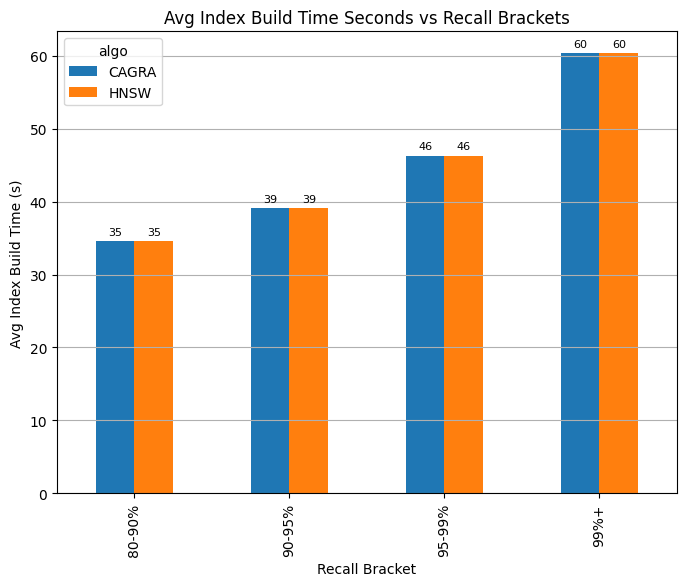

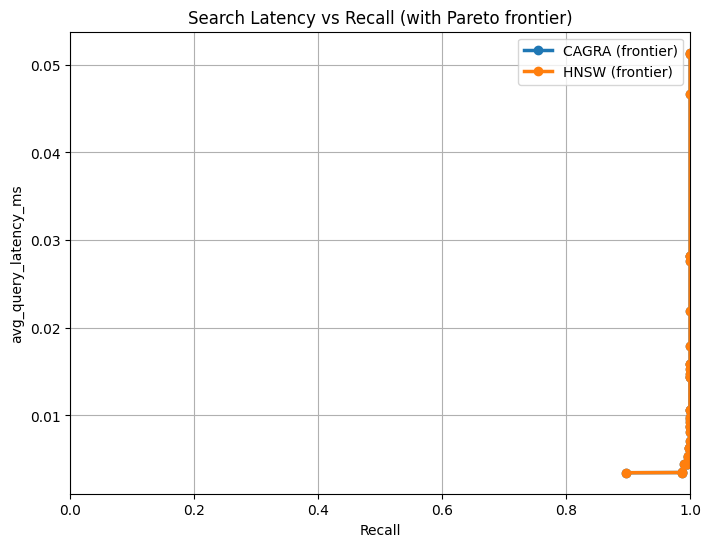

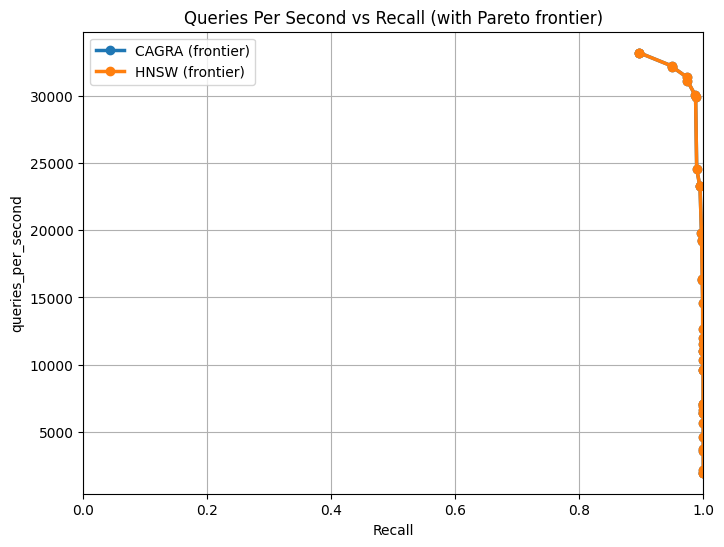

{'build': PosixPath('build_time_vs_recall_brackets.png'),
 'latency': PosixPath('avg_query_latency_ms_vs_recall.png'),
 'throughput': PosixPath('queries_per_second_vs_recall.png')}

In [2]:
#CAGRA low-rated vs HNSW low-rated (3 plots - build time, search latency, and throughput)
main_notebook('/raid/home/ubuntu/filtered-ads-vector-search/cagra_fp16_<1.0_4990000vecs_filter16pct_grid_search_results_new.csv',
             '/raid/home/ubuntu/filtered-ads-vector-search/cagra_fp16_<1.0_4990000vecs_filter16pct_grid_search_results_new.csv')

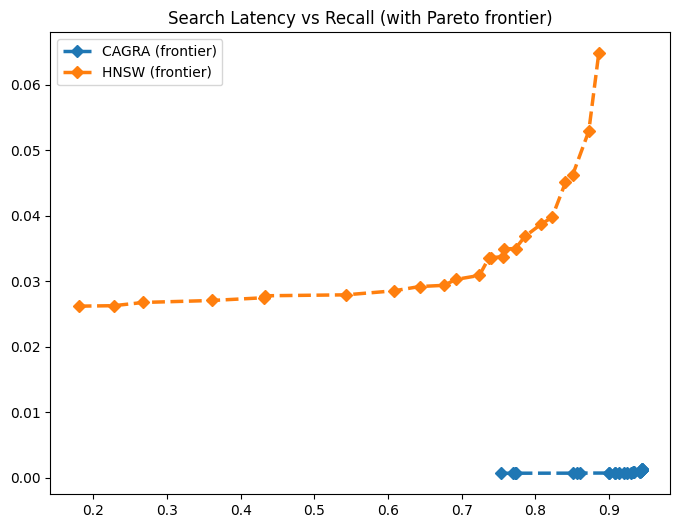

{'build': PosixPath('build_time_vs_recall_brackets.png'),
 'latency': PosixPath('avg_query_latency_ms_vs_recall.png'),
 'throughput': PosixPath('queries_per_second_vs_recall.png')}

In [21]:
#CAGRA high rated vs HNSW high rated (3 plots - build time, search latency and throughput)

main_notebook('cagra_fp16_ranges_3.0-4.0_4.0-5.0_=5.0_5000000vecs_filter84pct_grid_search_results_new.csv',
             'hnsw_fp16_ranges_3.0-4.0_4.0-5.0_=5.0_5000000vecs_filter84pct_grid_search_results_new.csv')